# Explain how to downsample the behavioural data to the same sampling rate as the neural data <br>
Jonas Braun <br>
jonas.braun@epfl.ch <br>
03.05.2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## load behavioural and neural data

In [2]:
beh_data_dir = "/mnt/labserver/_Teaching/_2102_BIOENG-456_CoBaR/Week9-mini-project/Data/COBAR_behaviour_incl_manual.pkl"
beh_df = pd.read_pickle(beh_data_dir)

In [3]:
neural_data_dir = "/mnt/labserver/_Teaching/_2102_BIOENG-456_CoBaR/Week8-Intro-mini-project/Data/COBAR_neural.pkl"
neural_df = pd.read_pickle(neural_data_dir)

## define function to resample

In [4]:
# these two functions are just wrappers around the numpy functions to apply them across dimension 0 only
def reduce_mean(values):
    return np.mean(values, axis=0)
def reduce_std(values):
    return np.std(values, axis=0)
def reduce_behaviour(values):
    """
    this is just a sketch for how to reduce behavioural classes. 
    It picks whatever behaviour occurs the most.
    Try to make this more stable, for example by handling the case when two behaviours are equally likely.
    You might also want to include a certainty threshold, 
    e.g. 3/4 of the behaviour frames have to be labelled the same way, otherwise it is None and the data is excluded
    """
    unique_values, N_per_unique = np.unique(values, return_counts=True)
    i_max = np.argmax(N_per_unique)
    return unique_values[i_max]

def reduce_during_2p_frame(twop_index, values, function=reduce_mean):
    """
    Reduces all values occuring during the acquisition of a
    two-photon imaging frame to a single value using the `function` given by the user.
    Parameters
    ----------
    twop_index : numpy array
        1d array holding frame indices of one trial.
    values : numpy array
        Values upsampled to the frequency of ThorSync,
        i.e. 1D numpy array of the same length as
        `frame_counter` or 2D numpy array of the same length.
    function : function
        Function used to reduce the value,
        e.g. np.mean for 1D variables
    Returns
    -------
    reduced : numpy array
        Numpy array with value for each two-photon imaging frame.
    """
    
    if len(twop_index) != len(values):
        raise ValueError("twop_index and values need to have the same length.")
    if len(values.shape) == 1:
        values = np.expand_dims(values, axis=1)
        squeeze = True
    else:
        squeeze = False
    N_samples, N_variables = values.shape
    
    index_unique = np.unique(twop_index)
    index_unique = np.delete(index_unique, index_unique==-9223372036854775808)
    
    dtype = values.dtype
    if np.issubdtype(dtype, np.number):
        dtype = np.float
    else:
        dtype = np.object
    reduced = np.empty((len(index_unique), N_variables), dtype=dtype)

    for i, index in enumerate(index_unique):
        reduced[i] = function(values[twop_index==index, :])

    return np.squeeze(reduced) if squeeze else reduced

# try out the function for one joint angle in the first trial

In [5]:
twop_index = beh_df.loc[(210301, "J1xCI9", 1, 0), "twop_index"].to_numpy()
# alternative: beh_df[beh_df.index.get_level_values("Trial")==0]["twop_index"].to_numpy()

In [7]:
np.unique(twop_index)

array([-9223372036854775808,                    0,                    1,
       ...,                 4037,                 4038,
                       4039])

In [10]:
np.__version__

'1.19.2'

In [11]:
pd.__version__

'1.2.4'

In [8]:
values = beh_df.loc[(210301, "J1xCI9", 1, 0), "angle_RF_leg_Coxa_yaw"].to_numpy()

In [9]:
reduced = reduce_during_2p_frame(twop_index, values, function=reduce_mean)

## comparing the results <br>
### note how the second plotting command uses the "t" variables of neural_df

<IPython.core.display.Javascript object>


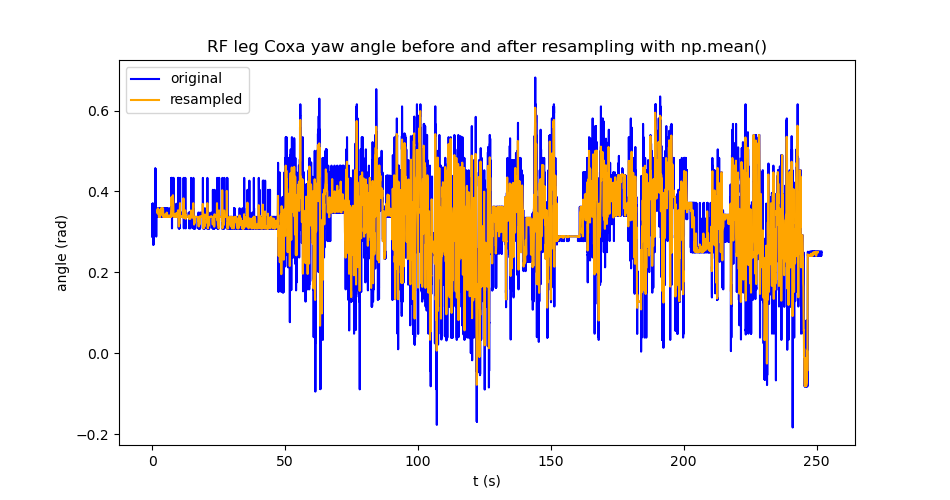

Text(0.5, 1.0, 'RF leg Coxa yaw angle before and after resampling with np.mean()')

In [8]:
%matplotlib notebook

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 5), sharex=True, sharey=True)
ax.plot(beh_df.loc[(210301, "J1xCI9", 1, 0), "t"], values, 'blue', label="original")
ax.plot(neural_df.loc[(210301, "J1xCI9", 1, 0), "t"], reduced, 'orange', label="resampled")
ax.set_xlabel("t (s)")
ax.set_ylabel("angle (rad)")
ax.legend()
ax.set_title("RF leg Coxa yaw angle before and after resampling with np.mean()")

## try out the function for multiple variables at the same time, e.g. all angles on the RF leg

In [9]:
twop_index = beh_df.loc[(210301, "J1xCI9", 1, 0), "twop_index"].to_numpy()
# alternative: beh_df[beh_df.index.get_level_values("Trial")==0]["twop_index"].to_numpy()

In [10]:
values = beh_df.loc[(210301, "J1xCI9", 1, 0)].filter(regex="angle_RF_leg").to_numpy()

In [11]:
reduced = reduce_during_2p_frame(twop_index, values, function=reduce_mean)

<IPython.core.display.Javascript object>


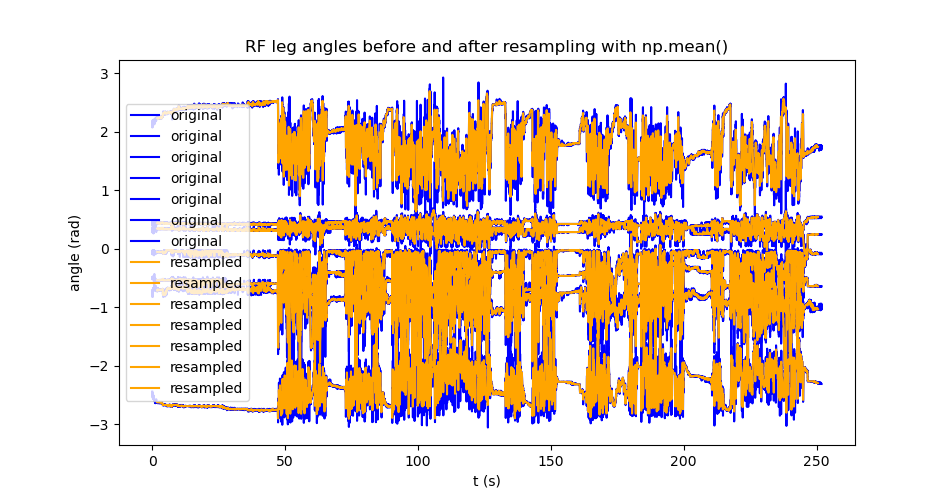

Text(0.5, 1.0, 'RF leg angles before and after resampling with np.mean()')

In [12]:
%matplotlib notebook

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 5), sharex=True, sharey=True)
ax.plot(beh_df.loc[(210301, "J1xCI9", 1, 0), "t"], values,'blue', label="original")
ax.plot(neural_df.loc[(210301, "J1xCI9", 1, 0), "t"], reduced, 'orange', label="resampled")
ax.set_xlabel("t (s)")
ax.set_ylabel("angle (rad)")
ax.legend()
ax.set_title("RF leg angles before and after resampling with np.mean()")

## P.S.: don't create plots where multiple lines have the same label, like in the one above

## try out the functions with behavioural categories

In [13]:
twop_index = beh_df.loc[(210301, "J1xCI9", 1, 0), "twop_index"].to_numpy()
values = beh_df.loc[(210301, "J1xCI9", 1, 0), "Manual"].to_numpy()


In [14]:
print(values)
print(len(values))

['resting' 'resting' 'resting' ... 'resting' 'resting' 'resting']
25200


In [15]:
reduced = reduce_during_2p_frame(twop_index, values, function=reduce_behaviour)

In [16]:
print(reduced)
print(len(reduced))

['resting' 'resting' 'resting' ... 'resting' 'resting' 'resting']
4040


## Generating the plots shown in the slides for week 10

In [17]:
# manually detected fluorescence baseline
neuron_1 = 100*(neural_df.loc[(210301, "J1xCI9", 1, 0), "neuron_15"]-610)/610
neuron_2 = 100*(neural_df.loc[(210301, "J1xCI9", 1, 0), "neuron_2"]-510)/510

<IPython.core.display.Javascript object>


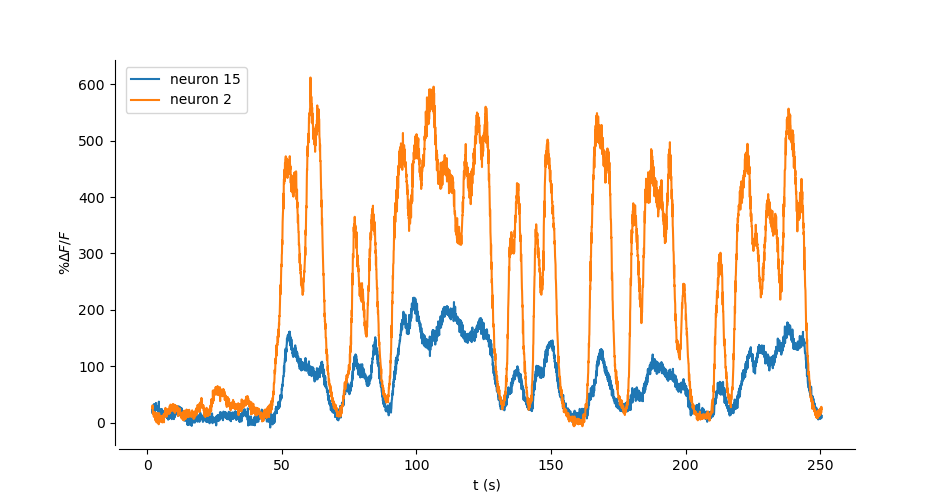

In [18]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 5))
ax.plot(neural_df.loc[(210301, "J1xCI9", 1, 0), "t"], neuron_1, label="neuron 15")
ax.plot(neural_df.loc[(210301, "J1xCI9", 1, 0), "t"], neuron_2, label="neuron 2")
ax.set_xlabel("t (s)")
ax.set_ylabel("$\% \Delta F/F$")
ax.legend()

ax.spines['left'].set_position(('outward', 3))  # ('axes', -0.02))  # 'zero'

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position(('outward', 3))  # ('axes', -0.02))  # 'zero'

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

<IPython.core.display.Javascript object>


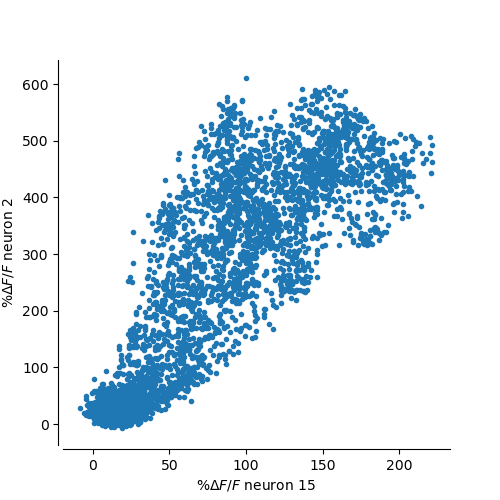

In [19]:
%matplotlib notebook

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(neuron_1, neuron_2, '.')
ax.set_xlabel("$\% \Delta F/F$ neuron 15")
ax.set_ylabel("$\% \Delta F/F$ neuron 2")
# ax.axis("on")

ax.spines['left'].set_position(('outward', 3))  # ('axes', -0.02))  # 'zero'

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position(('outward', 3))  # ('axes', -0.02))  # 'zero'

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

In [20]:
import scipy.stats
scipy.stats.pearsonr(neuron_1, neuron_2)

(0.8586661631629324, 0.0)

In [21]:
scipy.stats.spearmanr(neuron_1, neuron_2)

SpearmanrResult(correlation=0.8689750205076462, pvalue=0.0)

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
reg = LinearRegression().fit(X=np.expand_dims(neuron_1, axis=1), y=np.expand_dims(neuron_2, axis=1))

In [24]:
reg.score(X=np.expand_dims(neuron_1, axis=1), y=np.expand_dims(neuron_2, axis=1))

0.7373075797609518

In [25]:
reg.coef_

array([[2.82218741]])

In [26]:
reg.intercept_

array([20.45302253])

<IPython.core.display.Javascript object>


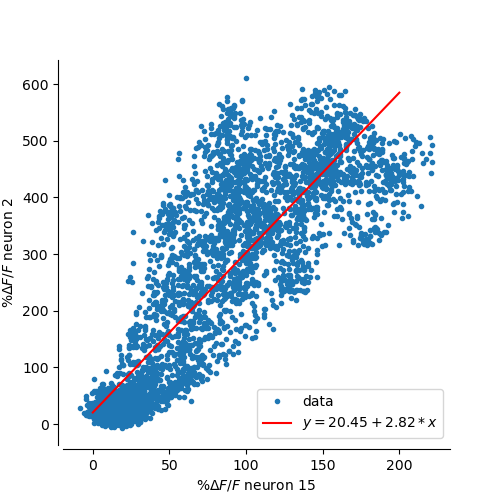

In [27]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(neuron_1, neuron_2, '.', label="data")
ax.plot([0, 200], [20.45302253, 20.45302253+200*2.82218741], 'r-', label="$y=20.45 + 2.82*x$")
ax.set_xlabel("$\% \Delta F/F$ neuron 15")
ax.set_ylabel("$\% \Delta F/F$ neuron 2")
# ax.axis("on")
ax.legend()

ax.spines['left'].set_position(('outward', 3))  # ('axes', -0.02))  # 'zero'

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position(('outward', 3))  # ('axes', -0.02))  # 'zero'

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()